# Usage of multinmrfit package

### Prepare environment

- Download and install Anaconda (>= 3.7) on your computer: https://www.anaconda.com/distribution/
- Install `multinmrfit`:
  - run "Anaconda prompt" from the start menu
  - install multinmrfit with: `python -m pip install git+https://github.com/NMRTeamTBI/MultiNMRFit.git@branch_name` (where 'branch_name' is the git branch you want to install)
- Start Jupyter from the start menu
- Open the jupyter notbook

Load some packages.

In [3]:
import logging
import sys
import pandas as pd

Initialize logger.

In [4]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.DEBUG, stream=sys.stdout)

Load multinmrfit.

In [5]:
import multinmrfit.base.spectrum as spectrum
import multinmrfit.base.io as io

## Load models.

Load models of signals implemented in multinmrfit.

In [6]:
available_models = io.IoHandler.get_models()

2023-01-09 13:39:18,294 | DEBUG : add model from file 'model_doublet.py'
2023-01-09 13:39:18,310 | DEBUG : model name: doublet
2023-01-09 13:39:18,311 | DEBUG : add model from file 'model_singlet.py'
2023-01-09 13:39:18,317 | DEBUG : model name: singlet
2023-01-09 13:39:18,318 | DEBUG : add model from file 'model_triplet.py'
2023-01-09 13:39:18,323 | DEBUG : model name: triplet


io.IoHandler.get_models() returns a dict with model_name-model_object as key-value pairs.

In [7]:
available_models.keys()

dict_keys(['doublet', 'singlet', 'triplet'])


In [11]:
available_models["doublet"]

multinmrfit.models.model_doublet.SignalModel

## Load NMR data.

Data can be loaded from a TSV file containing columns 'ppm' and 'intensity'.

In [14]:
test_synthetic_dataset = pd.read_table("./data/data_sim_nmrfit.csv", sep="\t")

In [15]:
test_synthetic_dataset.columns

Index(['ppm', 'intensity'], dtype='object')

Data can also be loaded from TopSpin files by providing all required information in a dictionnary.

In [18]:
test_topspin_dataset = {"data_path":"C:/Bruker/TopSpin4.0.7/data",
                        "dataset":"CFE_test",
                        "expno":"991",
                        "procno":"1",
                        "rowno":"3"}

The window of interest can be provided as a tuple containing lower and upper boundaries.

In [17]:
window = (-0.2, 0.2)

We can then load the data in a Spectrum object.

In [19]:
sp = spectrum.Spectrum(data=test_synthetic_dataset, window=window)

2023-01-09 13:43:02,919 | DEBUG : create Spectrum object


To view the spectrum, use the plot() method with exp=True.

In [40]:
fig = sp.plot(exp=True)

2023-01-09 13:51:08,770 | DEBUG : create plot


This method returns a plotly.graph_objects.Figure object that can be updated (e.g. to change the layout) and plotted.

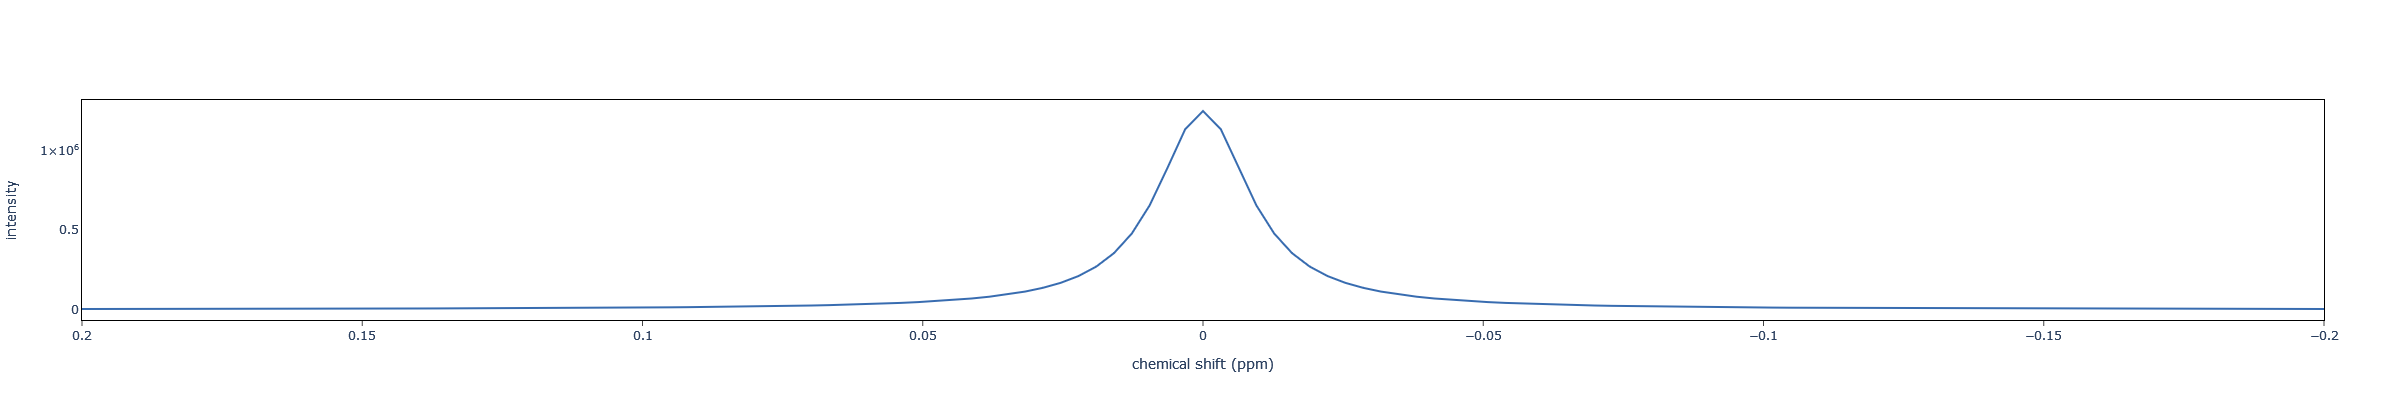

In [41]:
fig.update_layout(autosize=False, width=900, height=400)
fig.show()

## Peak picking.

Use the peak_picking() method with the threshold provided as argument.

In [21]:
peak_table = sp.peak_picking(1e6)

2023-01-09 13:43:19,704 | DEBUG : peak peaking
2023-01-09 13:43:19,741 | DEBUG : peak table
      intensity  ppm  X_AXIS  cID  X_LW           VOL
0  1.250091e+06  0.0    63.0    1   2.0  3.521388e+06


To visualize the spectrum and the identified peaks, use the plot() method with the peak_table provided as argument pp.

In [23]:
fig = sp.plot(pp=peak_table)

2023-01-09 13:45:55,661 | DEBUG : create plot


In [25]:
type(fig)

plotly.graph_objs._figure.Figure

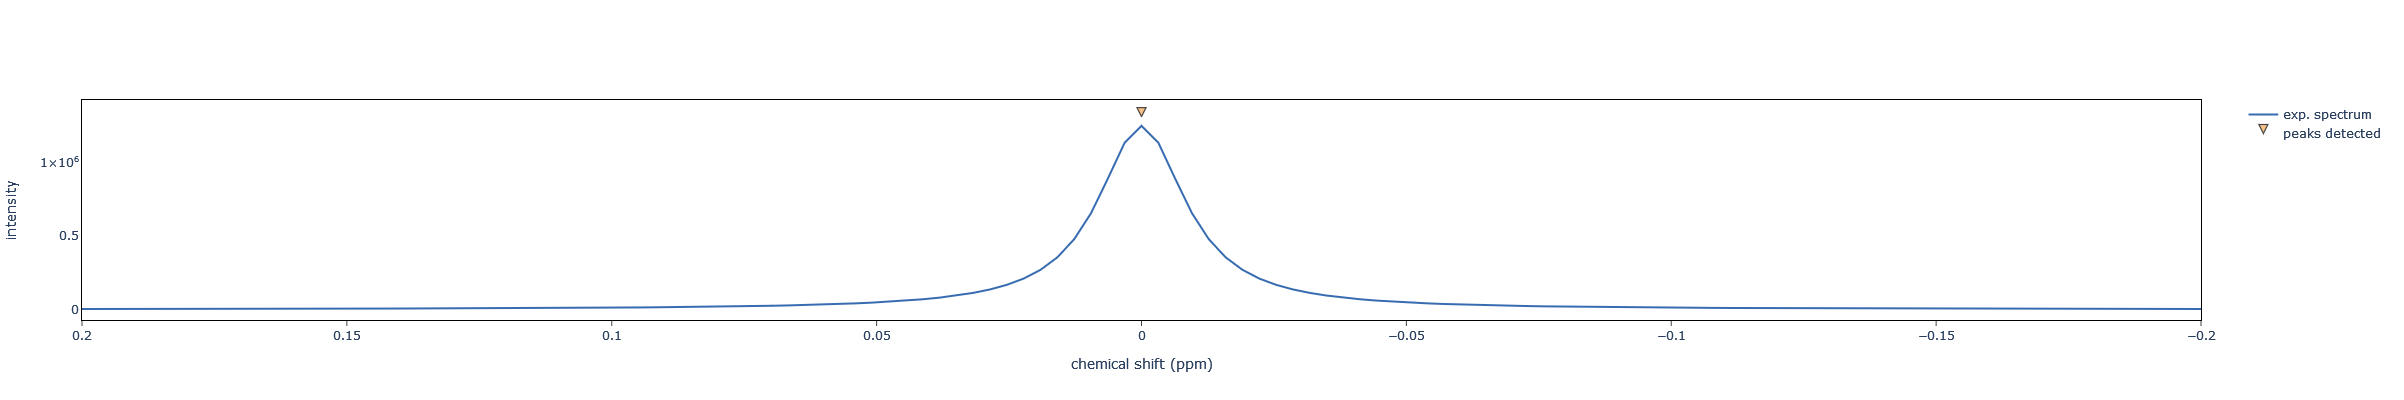

In [26]:
fig.update_layout(autosize=False, width=900, height=400)
fig.show()

## Spectrum simulation and fitting.

To simulate or fit a spectrum, we need to provide a list of signals containing the type of signal (e.g. singlet or doublet) and the corresponding parameters (chemical shift, coupling constant, linewidth, intensity, etc). Signals must be provided as a dictionary.

In [27]:


signals = {"singlet_TSP": {"model":"singlet", "par": {"x0": {"ini":0.0, "lb":-0.05, "ub":0.05}}}}

#signals = {"singlet_TSP": {"model":"singlet", "par": {"x0": {"ini":0.0, "lb":-0.05, "ub":0.05}}},
#           "doublet_TSP": {"model":"doublet", "par": {"x0": {"ini":-0.01, "lb":-0.01, "ub":0.01}, "J": {"ini":0.147, "lb":0.14, "ub":0.15}, "lw": {"ini":0.001}}}}


Then we can build a model of the spectrum.

In [35]:
sp.build_model(signals=signals, available_models=available_models)

2023-01-09 13:48:09,554 | DEBUG : build Model for signal 'singlet_TSP'
2023-01-09 13:48:09,558 | DEBUG : parameters
     signal_id    model        par         ini     lb            ub
0  singlet_TSP  singlet         x0        1.00  0.000  1.000000e+01
1  singlet_TSP  singlet  intensity  1000000.00  1.000  1.000000e+15
2  singlet_TSP  singlet         lw        0.01  0.001  3.000000e-02
3  singlet_TSP  singlet         gl        0.50  0.000  1.000000e+00


Parameters can be accessed via the params attibute.

In [36]:
sp.params

,signal_id,model,par,ini,lb,ub
0,singlet_TSP,singlet,x0,0.00,-0.050,5.000000e-02
1,singlet_TSP,singlet,intensity,1000000.00,1.000,1.000000e+15
2,singlet_TSP,singlet,lw,0.01,0.001,3.000000e-02
3,singlet_TSP,singlet,gl,0.50,0.000,1.000000e+00


We can update parameters and offser using the update_params() method.

In [37]:
sp.update_params({"singlet_TSP": {"par": {"intensity": {"ini":1e6, "ub":1e12}}}})

Similarly, we can update the offset with the update_offset() method. If offset=None, the offset is removed. To set an offset, provide a dictionary (if empty, offset is initialized to default values).

In [38]:
sp.update_offset(offset={})
print(sp.params)

       signal_id    model        par         ini             lb            ub
0    singlet_TSP  singlet         x0        0.00      -0.050000  5.000000e-02
1    singlet_TSP  singlet  intensity  1000000.00       1.000000  1.000000e+12
2    singlet_TSP  singlet         lw        0.01       0.001000  3.000000e-02
3    singlet_TSP  singlet         gl        0.50       0.000000  1.000000e+00
4  full_spectrum     None     offset        0.00 -250018.225728  2.500182e+05


In [39]:
sp.update_offset(offset=None)
print(sp.params)

     signal_id    model        par         ini     lb            ub
0  singlet_TSP  singlet         x0        0.00 -0.050  5.000000e-02
1  singlet_TSP  singlet  intensity  1000000.00  1.000  1.000000e+12
2  singlet_TSP  singlet         lw        0.01  0.001  3.000000e-02
3  singlet_TSP  singlet         gl        0.50  0.000  1.000000e+00


To fit experimental spectrum, use the fit() method.

In [21]:
sp.fit()

2023-01-09 11:13:17,813 | DEBUG : fit spectrum
2023-01-09 11:13:18,448 | DEBUG : parameters
       signal_id    model        par         ini             lb            ub  \
0    singlet_TSP  singlet         x0        0.00      -0.050000  5.000000e-02   
1    singlet_TSP  singlet  intensity  1000000.00       1.000000  1.000000e+12   
2    singlet_TSP  singlet         lw        0.01       0.001000  3.000000e-02   
3    singlet_TSP  singlet         gl        0.50       0.000000  1.000000e+00   
4  full_spectrum     None     offset        0.00 -250018.225728  2.500182e+05   

            opt       opt_sd      integral  
0  2.104864e-09     0.000008  39268.206279  
1  1.250001e+06  1109.179365  39268.206279  
2  9.999986e-03     0.000006  39268.206279  
3  1.000000e+00     0.000088  39268.206279  
4  9.126999e+01   102.252934           NaN  


Estimated parameters, standard deviations and integrals are now in the params attributes (columns 'opt', 'opt_sd' and 'integral', respectively).

In [24]:
sp.params

,signal_id,model,par,ini,lb,ub,opt,opt_sd,integral
0,singlet_TSP,singlet,x0,0.00,-0.050000,5.000000e-02,2.104864e-09,0.000008,39268.206279
1,singlet_TSP,singlet,intensity,1000000.00,1.000000,1.000000e+12,1.250001e+06,1109.179365,39268.206279
2,singlet_TSP,singlet,lw,0.01,0.001000,3.000000e-02,9.999986e-03,0.000006,39268.206279
3,singlet_TSP,singlet,gl,0.50,0.000000,1.000000e+00,1.000000e+00,0.000088,39268.206279
4,full_spectrum,None,offset,0.00,-250018.225728,2.500182e+05,9.126999e+01,102.252934,NaN


Fitting results can be viewed using the plot method with fit=True.

2023-01-09 11:13:18,498 | DEBUG : create plot


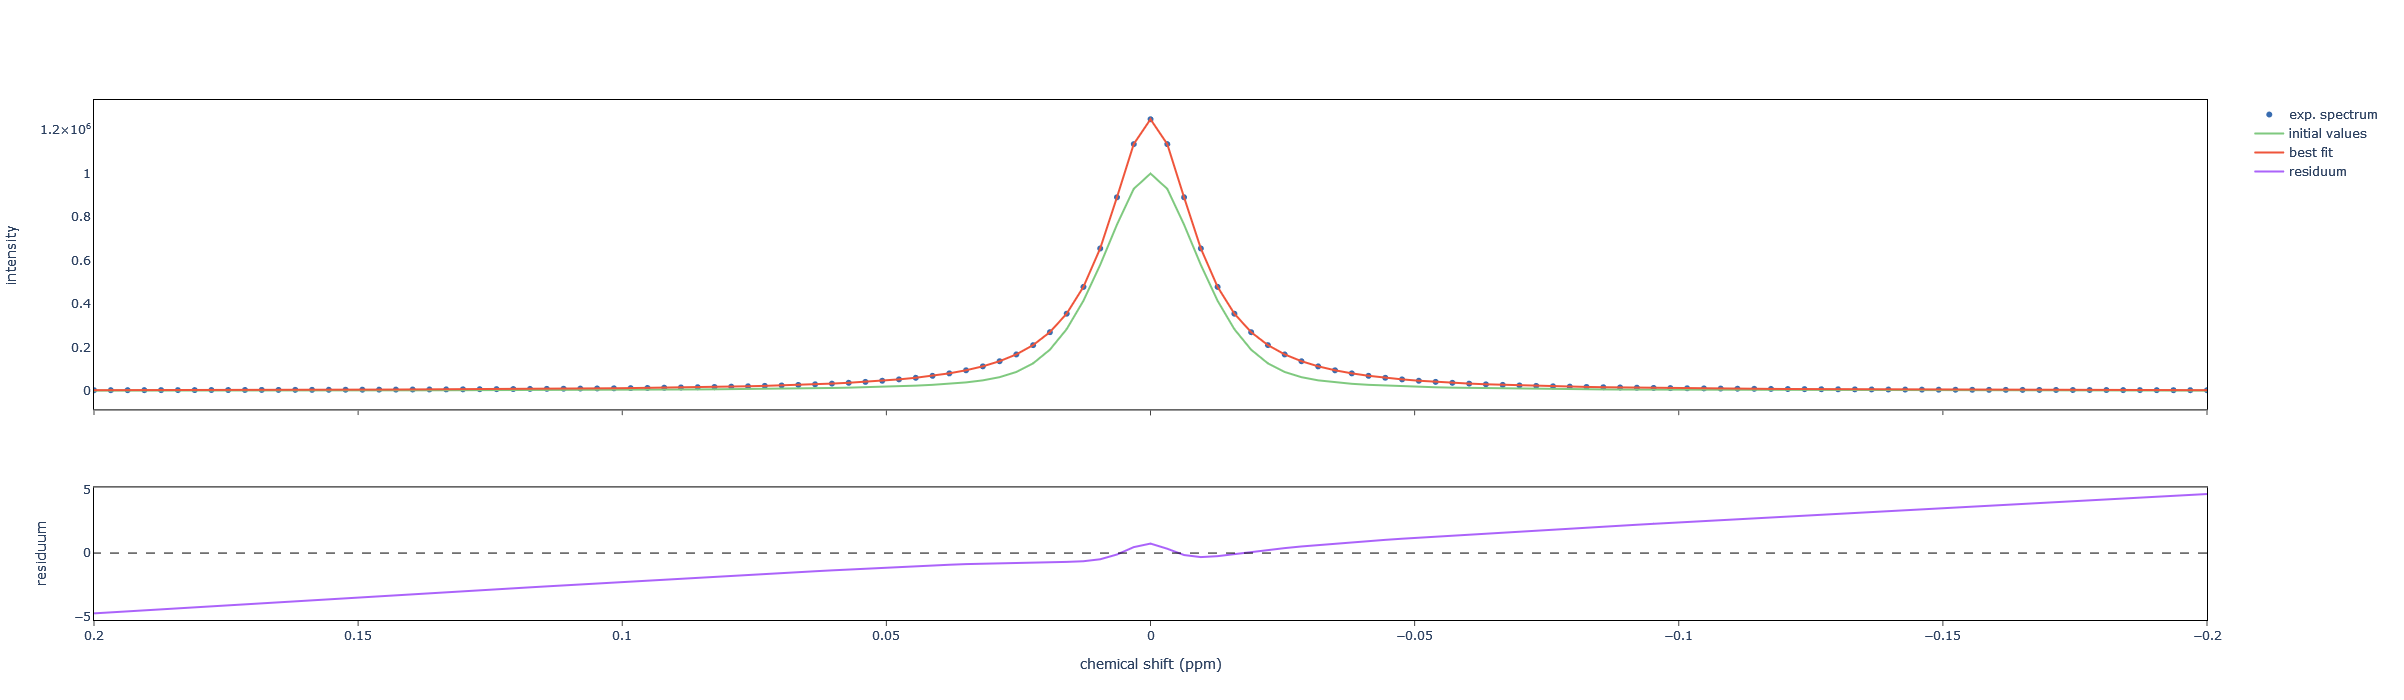

In [23]:
fig = sp.plot(ini=True, fit=True)
fig.update_layout(autosize=False, width=900, height=700)
fig.show()